# Cluster Analysis (Time-Series Features)
This notebook builds train-only daily series, extracts interpretable + time-series-specific features (including stationarity, AR structure, spectral features), and performs clustering with K selection.
All intermediate outputs are saved to `data-draft/` as Parquet.


In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

out_dir = Path('data/clustering')
out_dir.mkdir(parents=True, exist_ok=True)


## Load data (post-processed parquet)

In [2]:
DATA_DIR = Path('data')
p1 = DATA_DIR / 'Year_2009-2010_post.parquet'
p2 = DATA_DIR / 'Year_2010-2011_post.parquet'

df1 = pd.read_parquet(p1)
df2 = pd.read_parquet(p2)
df = pd.concat([df1, df2], ignore_index=True)
print('rows:', len(df), 'cols:', df.columns.tolist())


rows: 1067008 cols: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country', 'product_family_name', 'variant_hint']


## Prepare sales amount, split train/val/test, and apply cutoff (train only)

In [3]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
df['product_family_name'] = df['product_family_name'].astype('string').str.strip()
df = df[df['product_family_name'].notna() & (df['product_family_name'] != '')]

# sales_amount
if 'sales_amount' not in df.columns:
    if 'UnitPrice' in df.columns:
        price_col = 'UnitPrice'
    elif 'Price' in df.columns:
        price_col = 'Price'
    else:
        raise ValueError('No price column found (UnitPrice or Price)')
    df['sales_amount'] = df['Quantity'] * df[price_col]
else:
    price_col = 'UnitPrice' if 'UnitPrice' in df.columns else 'Price'

# time-based split (adjust if needed)
df = df.sort_values('InvoiceDate')
train_end = pd.Timestamp('2010-09-30')
val_end = pd.Timestamp('2010-11-30')

train_df = df[df['InvoiceDate'] <= train_end].copy()
val_df = df[(df['InvoiceDate'] > train_end) & (df['InvoiceDate'] <= val_end)].copy()
test_df = df[df['InvoiceDate'] > val_end].copy()

print('Train:', train_df['InvoiceDate'].min(), '?', train_df['InvoiceDate'].max(), 'rows', len(train_df))
print('Val:', val_df['InvoiceDate'].min(), '?', val_df['InvoiceDate'].max(), 'rows', len(val_df))
print('Test:', test_df['InvoiceDate'].min(), '?', test_df['InvoiceDate'].max(), 'rows', len(test_df))


Train: 2009-12-01 07:45:00 ? 2010-09-29 17:18:00 rows 363320
Val: 2010-09-30 08:59:00 ? 2010-11-29 17:46:00 rows 136846
Test: 2010-11-30 08:24:00 ? 2011-12-09 12:50:00 rows 566842


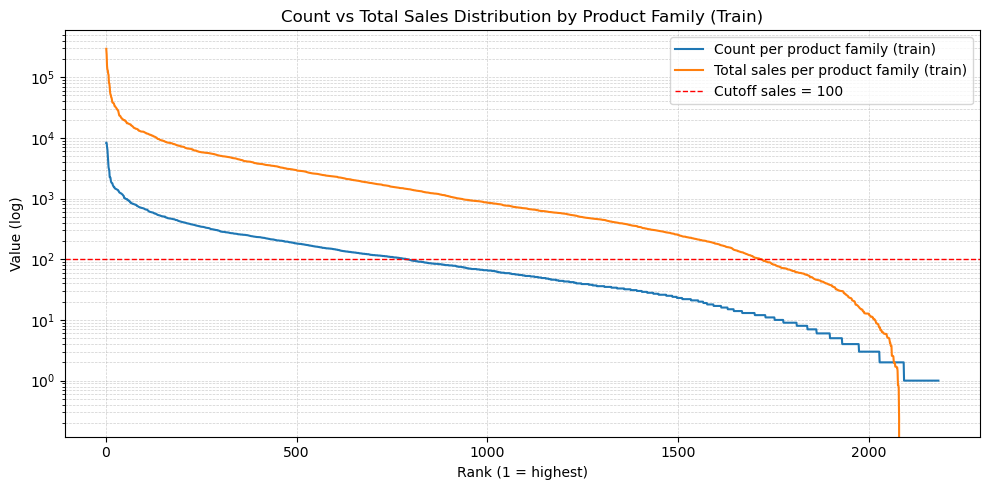

In [ ]:
# Use training set for plotting
vc = train_df['product_family_name'].value_counts()
vc_sorted = np.sort(vc.values)[::-1]
rank_counts = np.arange(1, len(vc_sorted) + 1)

sales_by_prod = (
    train_df.groupby('product_family_name')['sales_amount']
      .sum()
      .sort_values(ascending=False)
)
sales_sorted = sales_by_prod.values
rank_sales = np.arange(1, len(sales_sorted) + 1)

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(rank_counts, vc_sorted, color='tab:blue', label='Count per product family (train)')
ax.plot(rank_sales, sales_sorted, color='tab:orange', label='Total sales per product family (train)')

ax.set_yscale('log')
ax.set_xlabel('Rank (1 = highest)')
ax.set_ylabel('Value (log)')
ax.set_title('Count vs Total Sales Distribution by Product Family (Train)')

# cutoff line
ax.axhline(100, color='red', linestyle='--', linewidth=1, label='Cutoff sales = 100')

ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.6)
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [5]:
# cutoff based on train only
sales_train = train_df.groupby('product_family_name')['sales_amount'].sum()
keep_products = set(sales_train[sales_train >= 100].index)

train_df = train_df[train_df['product_family_name'].isin(keep_products)]
val_df = val_df[val_df['product_family_name'].isin(keep_products)]
test_df = test_df[test_df['product_family_name'].isin(keep_products)]

train_df.to_parquet(out_dir / 'train_df.parquet', index=False)
val_df.to_parquet(out_dir / 'val_df.parquet', index=False)
test_df.to_parquet(out_dir / 'test_df.parquet', index=False)
print('Saved train/val/test to data-draft')

Saved train/val/test to data-draft


## Build daily series (train only)

In [6]:
train_df['date'] = train_df['InvoiceDate'].dt.floor('D')
daily = (
    train_df.groupby(['product_family_name', 'date'])['sales_amount']
            .sum()
            .reset_index()
)
daily.to_parquet(out_dir / 'daily_train_sales.parquet', index=False)
print('Saved daily_train_sales.parquet')

full_index = pd.date_range(daily['date'].min(), daily['date'].max(), freq='D')


Saved daily_train_sales.parquet


## Feature helpers (including AR/Stationarity/Spectral/Intermittency)

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss, pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.sm_exceptions import InterpolationWarning

USE_MODEL_BASED = False  # set False if too slow
MAX_PACF_LAG = 14

# Seasonal period for ETS (weekly)
ETS_SEASONAL_PERIOD = 7

def longest_zero_streak(arr):
    max_run, run = 0, 0
    for v in arr:
        if v == 0:
            run += 1
            max_run = max(max_run, run)
        else:
            run = 0
    return max_run

def safe_autocorr(s: pd.Series, lag: int) -> float:
    s = s.fillna(0)
    if len(s) <= lag:
        return np.nan
    if s.std() == 0:
        return 0.0
    return s.autocorr(lag=lag)

def safe_pacf_vals(s: pd.Series, max_lag: int):
    s = s.fillna(0)
    if len(s) <= max_lag + 1 or s.std() == 0:
        return [np.nan] * (max_lag + 1)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)
        try:
            vals = pacf(s, nlags=max_lag, method='ywm')
            return vals
        except Exception:
            return [np.nan] * (max_lag + 1)

def stl_seasonality_strength(x, period=7):
    try:
        if len(x) < 2 * period:
            return np.nan
        res = STL(x, period=period, robust=True).fit()
        var_resid = np.var(res.resid)
        var_total = np.var(res.resid + res.seasonal)
        if var_total == 0:
            return 0.0
        return 1 - (var_resid / var_total)
    except Exception:
        return np.nan

def fft_features(y):
    y = np.asarray(y)
    if len(y) < 8 or np.all(y == y[0]):
        return np.nan, np.nan
    y = y - np.mean(y)
    n = len(y)
    freqs = np.fft.rfftfreq(n, d=1)
    power = np.abs(np.fft.rfft(y)) ** 2
    power[0] = 0
    if power.sum() == 0:
        return np.nan, np.nan
    dom_freq = freqs[np.argmax(power)]
    dom_period = 1.0 / dom_freq if dom_freq > 0 else np.nan
    p = power / power.sum()
    spectral_entropy = -np.sum(p * np.log(p + 1e-12)) / np.log(len(p))
    return dom_period, spectral_entropy

def stationarity_tests(y):
    if len(y) < 20 or np.std(y) == 0:
        return np.nan, np.nan
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", InterpolationWarning)
        try:
            adf_p = adfuller(y, maxlag=7, autolag='AIC')[1]
        except Exception:
            adf_p = np.nan
        try:
            kpss_p = kpss(y, nlags='auto')[1]
        except Exception:
            kpss_p = np.nan
    return adf_p, kpss_p

def intermittency_features(y):
    idx = np.where(y > 0)[0]
    if len(idx) <= 1:
        adi = len(y)
        cv2 = np.nan
    else:
        adi = np.mean(np.diff(idx))
        demand = y[idx]
        m = demand.mean()
        cv2 = ((demand.std() / m) ** 2) if m > 0 else np.nan
    return adi, cv2

def ar1_features(y):
    if len(y) < 20 or np.std(y) == 0:
        return np.nan, np.nan
    try:
        res = AutoReg(y, lags=1, old_names=False).fit()
        phi = res.params.get('L1.y', np.nan)
        sigma2 = np.var(res.resid)
        return phi, sigma2
    except Exception:
        return np.nan, np.nan

def ses_features(y):
    if len(y) < 20 or np.any(y < 0):
        return np.nan, np.nan
    try:
        fit = SimpleExpSmoothing(y, initialization_method='estimated').fit()
        alpha = fit.model.params.get('smoothing_level', np.nan)
        sse = fit.sse
        return alpha, sse
    except Exception:
        return np.nan, np.nan

def arima_features(y):
    # ARIMA(1,0,1) as a simple, interpretable baseline
    if len(y) < 30 or np.std(y) == 0:
        return np.nan, np.nan, np.nan, np.nan
    try:
        res = ARIMA(y, order=(1,0,1), enforce_stationarity=False, enforce_invertibility=False).fit()
        ar1 = res.params.get('ar.L1', np.nan)
        ma1 = res.params.get('ma.L1', np.nan)
        sigma2 = res.params.get('sigma2', np.nan)
        aic = res.aic
        return ar1, ma1, sigma2, aic
    except Exception:
        return np.nan, np.nan, np.nan, np.nan

def ets_features(y):
    # ETS with additive trend and weekly seasonality (if enough data)
    if len(y) < 2 * ETS_SEASONAL_PERIOD or np.any(y < 0):
        return np.nan, np.nan, np.nan, np.nan, np.nan
    try:
        fit = ExponentialSmoothing(
            y,
            trend='add',
            seasonal='add',
            seasonal_periods=ETS_SEASONAL_PERIOD,
            initialization_method='estimated'
        ).fit()
        alpha = fit.params.get('smoothing_level', np.nan)
        beta = fit.params.get('smoothing_trend', np.nan)
        gamma = fit.params.get('smoothing_seasonal', np.nan)
        sse = fit.sse
        resid = y - fit.fittedvalues
        resid_var = np.var(resid)
        return alpha, beta, gamma, sse, resid_var
    except Exception:
        return np.nan, np.nan, np.nan, np.nan, np.nan

def croston_tsb_features(y):
    # Croston / TSB-like summary features (interpretable)
    idx = np.where(y > 0)[0]
    if len(idx) == 0:
        return np.nan, np.nan, 0.0, 0.0, np.nan, 0.0
    demand = y[idx]
    mean_demand = demand.mean()
    if len(idx) > 1:
        mean_interval = np.mean(np.diff(idx))
    else:
        mean_interval = len(y)
    croston_forecast = mean_demand / mean_interval if mean_interval > 0 else np.nan

    tsb_p = len(idx) / len(y)
    tsb_z = mean_demand
    tsb_forecast = tsb_p * tsb_z

    return mean_demand, mean_interval, croston_forecast, tsb_p, tsb_z, tsb_forecast


# Feature Definitions (Time‑Series Clustering)

## **A) Core Features (always computed)**

**Demand sparsity / intermittency**
- **`nonzero_rate`**:  
  Fraction of days with non‑zero sales.  
  $$
  \text{nonzero\_rate} = \frac{\#\{y_t \neq 0\}}{T}
  $$
- **`avg_gap`**:  
  Mean gap (in days) between consecutive non‑zero sales days.  
  $$
  \text{avg\_gap} = \frac{1}{(n_{nz}-1)}\sum_{i=2}^{n_{nz}} (t_i - t_{i-1})
  $$
- **`longest_zero_streak`**:  
  Maximum run length of consecutive zero‑sales days.

**Autocorrelation / seasonality**
- **`acf_1`, `acf_7`, `acf_14`, `acf_30`**:  
  Autocorrelation at lag 1/7/14/30:
  $$
  \rho_k = \frac{\sum_t (y_t-\bar y)(y_{t-k}-\bar y)}{\sum_t (y_t-\bar y)^2}
  $$
- **`pacf_1`, `pacf_7`, `pacf_14`**:  
  Partial autocorrelation at lag 1/7/14 (Yule‑Walker / YWM).
- **`stl_seasonality_strength`**:  
  STL seasonal strength (weekly period).  
  $$
  S = 1 - \frac{\mathrm{Var}(\text{resid})}{\mathrm{Var}(\text{resid}+\text{seasonal})}
  $$

**Volatility / stability**
- **`cv`** (coefficient of variation):  
  $$
  \text{cv} = \frac{\sigma_y}{\mu_y}
  $$
- **`rolling_std_mean_ratio`**:  
  Mean of rolling 7‑day \(\frac{\sigma}{\mu}\) ratio.

**Trend**
- **`trend_slope`**:  
  Slope from a linear fit on 7‑day rolling mean.  
  $$
  \hat{y}_t = a + bt \Rightarrow \text{slope}=b
  $$
- **`net_growth`**:  
  Last minus first value of the rolling mean.

**Burst / peaks**
- **`peak_days`**:  
  Count of days with sales ≥ 95th percentile of positive sales.
- **`peak_size`**:  
  95th percentile of positive sales.

**Level / value**
- **`mean_daily_sales`**:  
  Mean daily sales amount.
- **`total_sales`**:  
  Sum of sales across all days.

**Returns**
- **`neg_day_rate`**:  
  Fraction of days with negative sales (returns).  
  $$
  \text{neg\_day\_rate} = \frac{\#\{y_t < 0\}}{T}
  $$

**Spectral features**
- **`dominant_period`**:  
  Period (in days) from the strongest FFT frequency.
- **`spectral_entropy`**:  
  Normalized entropy of FFT power spectrum.  
  $$
  H = -\frac{\sum p_i \log p_i}{\log N}
  $$

**Stationarity**
- **`adf_pvalue`**:  
  p‑value from Augmented Dickey‑Fuller (unit root test).
- **`kpss_pvalue`**:  
  p‑value from KPSS stationarity test.

**Intermittency (Croston diagnostics)**
- **`adi`** (Average Demand Interval):  
  Mean interval between non‑zero sales.
- **`cv2`** (Squared coefficient of variation of non‑zero demand):  
  $$
  \text{cv2} = \left(\frac{\sigma_{demand}}{\mu_{demand}}\right)^2
  $$

**Croston / TSB‑style summary**
- **`croston_mean_demand`**: mean of non‑zero demand sizes.  
- **`croston_mean_interval`**: mean interval between demands.  
- **`croston_forecast`**:  
  $$
  \hat{y} = \frac{\text{mean demand}}{\text{mean interval}}
  $$
- **`tsb_p`**: demand occurrence probability \((\#\text{nonzero})/T\)  
- **`tsb_z`**: mean demand size  
- **`tsb_forecast`**:  
  $$
  \hat{y} = \text{tsb\_p} \times \text{tsb\_z}
  $$

---

## **B) Optional Model‑Based Features (USE_MODEL_BASED=True)**

Below is **Part B (Model‑Based Features)** rewritten with formulas.


**AR(1)**
Model:
$$
y_t = \phi\,y_{t-1} + \varepsilon_t
$$
- **`ar1_phi`**: estimated \(\phi\)  
- **`ar1_resid_var`**:  
$$
\hat{\sigma}^2 = \mathrm{Var}(\hat{\varepsilon}_t)
$$


**SES (Simple Exponential Smoothing)**
Model:
$$
\hat{y}_{t|t-1} = \ell_{t-1}
\quad,\quad
\ell_t = \alpha y_t + (1-\alpha)\ell_{t-1}
$$
- **`ses_alpha`**: smoothing parameter \(\alpha\)  
- **`ses_sse`**:  
$$
\text{SSE} = \sum_t (y_t - \hat{y}_{t|t-1})^2
$$


**ARIMA(1,0,1)**
Model:
$$
y_t = \phi y_{t-1} + \varepsilon_t + \theta \varepsilon_{t-1}
$$
- **`arima_ar1`**: \(\phi\)  
- **`arima_ma1`**: \(\theta\)  
- **`arima_sigma2`**: \(\sigma^2\) (innovation variance)  
- **`arima_aic`**:  
$$
\text{AIC} = 2k - 2\ln(\hat{L})
$$


 **ETS (Additive Trend + Additive Seasonality)**
Additive Holt‑Winters (period = \(m\)):
$$
\begin{aligned}
\ell_t &= \alpha (y_t - s_{t-m}) + (1-\alpha)(\ell_{t-1}+b_{t-1}) \\\\
b_t &= \beta (\ell_t - \ell_{t-1}) + (1-\beta)b_{t-1} \\\\
s_t &= \gamma (y_t - \ell_t) + (1-\gamma)s_{t-m} \\\\
\hat{y}_{t+h} &= \ell_t + h b_t + s_{t-m+h}
\end{aligned}
$$
- **`ets_alpha`**: \(\alpha\) (level smoothing)  
- **`ets_beta`**: \(\beta\) (trend smoothing)  
- **`ets_gamma`**: \(\gamma\) (seasonal smoothing)  
- **`ets_sse`**:  
$$
\text{SSE} = \sum_t (y_t - \hat{y}_t)^2
$$
- **`ets_resid_var`**:  
$$
\mathrm{Var}(y_t - \hat{y}_t)
$$

## **Notes for Reporting**
- **Median** profiles are used for cluster interpretation (robust to outliers).
- **Mean–median shift** is reported separately to quantify outlier influence.
- Model‑based features are **optional** and may be disabled for speed or stability.

## Feature extraction (including model-based features)

In [8]:
def extract_features(s: pd.Series) -> dict:
    y = s.values.astype(float)
    n = len(y)
    nonzero = y != 0
    nz_idx = np.where(nonzero)[0]

    # sparsity
    nonzero_rate = nonzero.mean()
    avg_gap = np.mean(np.diff(nz_idx)) if len(nz_idx) > 1 else n
    lz = longest_zero_streak(y)

    # volatility
    mean_y = y.mean()
    std_y = y.std()
    cv = std_y / mean_y if mean_y != 0 else 0.0
    roll = pd.Series(y).rolling(7, min_periods=3)
    roll_ratio = (roll.std() / roll.mean()).replace([np.inf, -np.inf], np.nan).mean()

    # trend
    roll_mean = pd.Series(y).rolling(7, min_periods=3).mean().fillna(0).values
    slope = np.polyfit(np.arange(n), roll_mean, 1)[0] if n > 1 else 0.0
    net_growth = (roll_mean[-1] - roll_mean[0]) if n > 1 else 0.0

    # seasonality + ACF/PACF
    acf_1 = safe_autocorr(pd.Series(y), 1)
    acf_7 = safe_autocorr(pd.Series(y), 7)
    acf_14 = safe_autocorr(pd.Series(y), 14)
    acf_30 = safe_autocorr(pd.Series(y), 30)
    pacf_vals = safe_pacf_vals(pd.Series(y), MAX_PACF_LAG)
    pacf_1 = pacf_vals[1] if len(pacf_vals) > 1 else np.nan
    pacf_7 = pacf_vals[7] if len(pacf_vals) > 7 else np.nan
    pacf_14 = pacf_vals[14] if len(pacf_vals) > 14 else np.nan
    stl_strength = stl_seasonality_strength(pd.Series(y), period=7)

    # peaks / bursts
    pos = y[y > 0]
    p95 = np.percentile(pos, 95) if len(pos) > 0 else 0
    peak_days = (y >= p95).sum() if p95 > 0 else 0
    peak_size = p95

    # returns
    neg_rate = (y < 0).mean()

    # spectral + stationarity + intermittency
    dom_period, spectral_entropy = fft_features(y)
    adf_p, kpss_p = stationarity_tests(y)
    adi, cv2 = intermittency_features(y)

    # Croston/TSB-like features
    croston_mean_demand, croston_mean_interval, croston_forecast, tsb_p, tsb_z, tsb_forecast = croston_tsb_features(y)

    # model-based features
    if USE_MODEL_BASED:
        ar1_phi, ar1_sigma2 = ar1_features(y)
        ses_alpha, ses_sse = ses_features(y)
        arima_ar1, arima_ma1, arima_sigma2, arima_aic = arima_features(y)
        ets_alpha, ets_beta, ets_gamma, ets_sse, ets_resid_var = ets_features(y)
    else:
        ar1_phi, ar1_sigma2 = np.nan, np.nan
        ses_alpha, ses_sse = np.nan, np.nan
        arima_ar1, arima_ma1, arima_sigma2, arima_aic = np.nan, np.nan, np.nan, np.nan
        ets_alpha, ets_beta, ets_gamma, ets_sse, ets_resid_var = np.nan, np.nan, np.nan, np.nan, np.nan

    return {
        'nonzero_rate': nonzero_rate,
        'avg_gap': avg_gap,
        'longest_zero_streak': lz,
        'acf_1': acf_1,
        'acf_7': acf_7,
        'acf_14': acf_14,
        'acf_30': acf_30,
        'pacf_1': pacf_1,
        'pacf_7': pacf_7,
        'pacf_14': pacf_14,
        'stl_seasonality_strength': stl_strength,
        'cv': cv,
        'rolling_std_mean_ratio': roll_ratio,
        'trend_slope': slope,
        'net_growth': net_growth,
        'peak_days': peak_days,
        'peak_size': peak_size,
        'mean_daily_sales': mean_y,
        'total_sales': y.sum(),
        'neg_day_rate': neg_rate,
        'dominant_period': dom_period,
        'spectral_entropy': spectral_entropy,
        'adf_pvalue': adf_p,
        'kpss_pvalue': kpss_p,
        'adi': adi,
        'cv2': cv2,
        'croston_mean_demand': croston_mean_demand,
        'croston_mean_interval': croston_mean_interval,
        'croston_forecast': croston_forecast,
        'tsb_p': tsb_p,
        'tsb_z': tsb_z,
        'tsb_forecast': tsb_forecast,
        'ar1_phi': ar1_phi,
        'ar1_resid_var': ar1_sigma2,
        'ses_alpha': ses_alpha,
        'ses_sse': ses_sse,
        'arima_ar1': arima_ar1,
        'arima_ma1': arima_ma1,
        'arima_sigma2': arima_sigma2,
        'arima_aic': arima_aic,
        'ets_alpha': ets_alpha,
        'ets_beta': ets_beta,
        'ets_gamma': ets_gamma,
        'ets_sse': ets_sse,
        'ets_resid_var': ets_resid_var,
    }

rows = []
for i, (prod, g) in enumerate(daily.groupby('product_family_name')):
    s = g.set_index('date')['sales_amount'].reindex(full_index, fill_value=0)
    feats = extract_features(s)
    feats['product_family_name'] = prod
    rows.append(feats)
    if (i + 1) % 200 == 0:
        print('processed', i + 1)

feat_df = pd.DataFrame(rows).set_index('product_family_name')

# add price stats / customer breadth / basket size
price_stats = train_df.groupby('product_family_name')[price_col].agg(['mean', 'std']).rename(
    columns={'mean': 'price_mean', 'std': 'price_std'}
)
feat_df = feat_df.join(price_stats, how='left')

if 'Customer ID' in train_df.columns:
    feat_df['unique_customers'] = train_df.groupby('product_family_name')['Customer ID'].nunique()
if 'Country' in train_df.columns:
    feat_df['unique_countries'] = train_df.groupby('product_family_name')['Country'].nunique()
if 'Invoice' in train_df.columns:
    basket = (
        train_df.groupby(['product_family_name', 'Invoice'])['Quantity']
                .sum()
                .groupby('product_family_name')
                .mean()
    )
    feat_df['avg_basket_size'] = basket

feat_df = feat_df.replace([np.inf, -np.inf], np.nan).fillna(0)
feat_df.to_parquet(out_dir / 'feature_table_extended.parquet', index=True)
print('Saved feature_table_extended.parquet')


processed 200
processed 400
processed 600
processed 800
processed 1000
processed 1200
processed 1400
processed 1600
Saved feature_table_extended.parquet


## Standardize features

In [9]:
from sklearn.preprocessing import StandardScaler

X = feat_df.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, index=feat_df.index, columns=feat_df.columns)
X_scaled_df.to_parquet(out_dir / 'feature_table_extended_scaled.parquet', index=True)
print('Saved feature_table_extended_scaled.parquet')


Saved feature_table_extended_scaled.parquet


https://scikit-learn.org/stable/modules/clustering.html

**Best‑fit models for this problem**
1. **GMM (Gaussian Mixture)**
   - Why: soft membership, handles overlapping behaviors, BIC gives principled K.
   - Fit: strong for business segments where boundaries are fuzzy.
2. **K‑Means / Bisecting K‑Means**
   - Why: fast, stable, easy to explain; good baseline.
   - Fit: works if clusters are roughly spherical in feature space.
3. **HDBSCAN**
   - Why: detects long‑tail/noise; no need to pre‑choose K.
   - Fit: great for intermittent demand and outliers.
4. **Agglomerative (Ward)**
   - Why: yields a dendrogram for interpretability; you can cut at K later.
   - Fit: useful when you want a hierarchical story.

**Models to avoid here (less fit for your target)**
1. **Affinity Propagation / Mean‑Shift**
   - Not scalable; sensitive to parameters; no clear business K control.
2. **Spectral Clustering**
   - Expensive for large n; needs small K; not ideal for many products.
3. **DBSCAN / OPTICS**
   - Struggles in high‑dimensional feature space; very sensitive to epsilon; can label most points as noise (as you already saw with HDBSCAN).
4. **BIRCH**
   - Mainly for massive datasets; less interpretable and often inferior to KMeans/GMM for your size.

## MODEL SELECTION

Saved k_selection_metrics.parquet


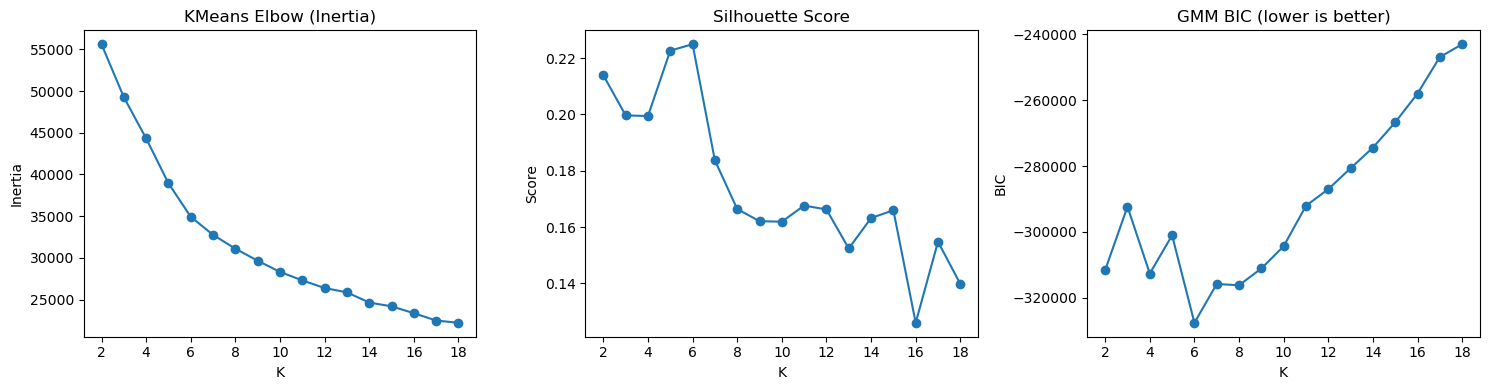

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

ks = range(2, 19)
inertias, sils, bics = [], [], []

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X_scaled, labels))

    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X_scaled)
    bics.append(gmm.bic(X_scaled))

metrics_df = pd.DataFrame({'k': list(ks), 'inertia': inertias, 'silhouette': sils, 'bic': bics})
metrics_df.to_parquet(out_dir / 'k_selection_metrics.parquet', index=False)
print('Saved k_selection_metrics.parquet')

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].plot(metrics_df['k'], metrics_df['inertia'], marker='o')
axes[0].set_title('KMeans Elbow (Inertia)')
axes[0].set_xlabel('K')
axes[0].set_ylabel('Inertia')

axes[1].plot(metrics_df['k'], metrics_df['silhouette'], marker='o')
axes[1].set_title('Silhouette Score')
axes[1].set_xlabel('K')
axes[1].set_ylabel('Score')

axes[2].plot(metrics_df['k'], metrics_df['bic'], marker='o')
axes[2].set_title('GMM BIC (lower is better)')
axes[2].set_xlabel('K')
axes[2].set_ylabel('BIC')

plt.tight_layout()
plt.show()



GMM Bayesian Information Criterion: https://www.geeksforgeeks.org/machine-learning/bayesian-information-criterion-bic/

$$BIC = -2ln(L) + kln(n)$$


In [ ]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# Choose K (set manually or from earlier metrics)
K_KMEANS = 5
K_GMM = 6

# KMeans
km = KMeans(n_clusters=K_KMEANS, random_state=42, n_init=10)
feat_df["cluster_kmeans"] = km.fit_predict(X_scaled)

# GMM
gmm = GaussianMixture(n_components=K_GMM, random_state=42)
feat_df["cluster_gmm"] = gmm.fit_predict(X_scaled)

# HDBSCAN (no K)
try:
    import hdbscan
    hdb = hdbscan.HDBSCAN(min_cluster_size=30, min_samples=5)
    feat_df["cluster_hdbscan"] = hdb.fit_predict(X_scaled)
except Exception as e:
    print("HDBSCAN skipped:", e)

# save labels
feat_df[["cluster_kmeans","cluster_gmm","cluster_hdbscan"]].to_parquet(
   out_dir /  "clusters_3models.parquet", index=True
)

# size share comparison
size_df = pd.DataFrame({
    "kmeans": feat_df["cluster_kmeans"].value_counts(normalize=True),
    "gmm": feat_df["cluster_gmm"].value_counts(normalize=True),
    "hdbscan": feat_df["cluster_hdbscan"].value_counts(normalize=True)
}).fillna(0).sort_index()

size_df.to_parquet( out_dir / "cluster_size_share_3models.parquet")
size_df


,kmeans,gmm,hdbscan
-1,0.000000,0.000000,1.0
0,0.562864,0.113504,0.0
1,0.198487,0.437136,0.0
2,0.006985,0.006985,0.0
3,0.227590,0.233411,0.0
4,0.004075,0.204889,0.0
5,0.000000,0.004075,0.0


In [12]:
from sklearn.metrics import adjusted_rand_score
import seaborn as sns

seeds = [1, 12, 123, 1234, 12345]

# KMeans ARI
labels_km = []
for s in seeds:
    km = KMeans(n_clusters=K_KMEANS, random_state=s, n_init=10)
    labels_km.append(km.fit_predict(X_scaled))

rows = []
for i in range(len(seeds)):
    for j in range(i+1, len(seeds)):
        ari = adjusted_rand_score(labels_km[i], labels_km[j])
        rows.append({"model": "kmeans", "seed_i": seeds[i], "seed_j": seeds[j], "ari": ari})

# GMM ARI
labels_gmm = []
for s in seeds:
    gmm = GaussianMixture(n_components=K_GMM, random_state=s)
    gmm.fit(X_scaled)
    labels_gmm.append(gmm.predict(X_scaled))

for i in range(len(seeds)):
    for j in range(i+1, len(seeds)):
        ari = adjusted_rand_score(labels_gmm[i], labels_gmm[j])
        rows.append({"model": "gmm", "seed_i": seeds[i], "seed_j": seeds[j], "ari": ari})

ari_df = pd.DataFrame(rows)
ari_df.to_parquet(out_dir / "cluster_stability_ari_3models.parquet", index=False)
ari_df


,model,seed_i,seed_j,ari
0,kmeans,1,12,0.997141
1,kmeans,1,123,0.995768
2,kmeans,1,1234,0.995768
3,kmeans,1,12345,0.993867
4,kmeans,12,123,0.998627
5,kmeans,12,1234,0.998627
6,kmeans,12,12345,0.996722
7,kmeans,123,1234,1.000000
8,kmeans,123,12345,0.998095
9,kmeans,1234,12345,0.998095


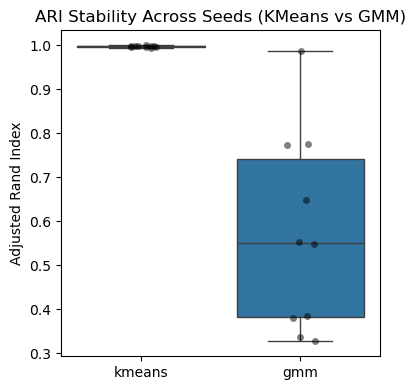

In [13]:
plt.figure(figsize=(4,4))
sns.boxplot(data=ari_df, x="model", y="ari")
sns.stripplot(data=ari_df, x="model", y="ari", color="black", alpha=0.5, jitter=0.1)
plt.title("ARI Stability Across Seeds (KMeans vs GMM)")
plt.ylabel("Adjusted Rand Index")
plt.xlabel("")
plt.tight_layout()
plt.show()

Saved: kmeans_k5_cluster_profiles_small.parquet


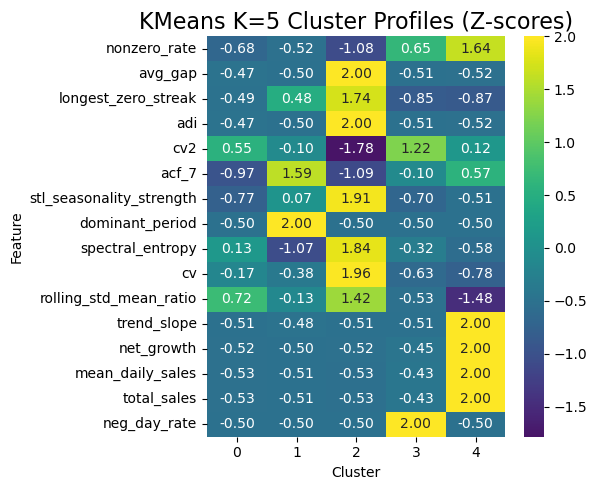

In [14]:
# Small, interpretable subset (business-facing)
profile_cols = [
    # demand sparsity / intermittency
    "nonzero_rate", "avg_gap", "longest_zero_streak", "adi", "cv2",
    # seasonality / periodicity
    "acf_7", "stl_seasonality_strength", "dominant_period", "spectral_entropy",
    # volatility / stability
    "cv", "rolling_std_mean_ratio",
    # trend
    "trend_slope", "net_growth",
    # level / value
    "mean_daily_sales", "total_sales",
    # returns
    "neg_day_rate"
]

# Cluster profiles using median (robust to outliers)
cluster_profiles = (
    feat_df.groupby("cluster_kmeans")[profile_cols]
           .median()
)

cluster_sizes = feat_df["cluster_kmeans"].value_counts().sort_index()
cluster_profiles["cluster_size"] = cluster_sizes

cluster_profiles.to_parquet(out_dir / "kmeans_k5_cluster_profiles_small.parquet")
print("Saved: kmeans_k5_cluster_profiles_small.parquet")

# Z-score for visualization
Z = pd.DataFrame(
    StandardScaler().fit_transform(cluster_profiles[profile_cols]),
    index=cluster_profiles.index,
    columns=profile_cols
)

Z_sub = Z[profile_cols]

features = list(Z_sub.columns)
ypos = np.arange(len(features)) + 0.5  # centers

# Create a single plot for the heatmap
fig, ax = plt.subplots(figsize=(6, 5)) # Adjusted figsize for a single plot

# Heatmap
sns.heatmap(
    Z_sub.T,
    cmap="viridis",
    center=0,
    ax=ax,
    cbar=True,
    annot=True, # Added annotations for clarity
    fmt=".2f"
)
ax.set_title("KMeans K=5 Cluster Profiles (Z-scores)", fontsize=16)
ax.set_xlabel("Cluster")
ax.set_ylabel("Feature")
ax.set_yticks(ypos)
ax.set_yticklabels(features)

plt.tight_layout()
plt.show()



## **Mean vs Median (Which to use?)**

**Use median** for cluster profiling if:
- the data is **skewed or heavy‑tailed** (which retail sales usually are),
- there are **outliers** (promotions, returns),
- you care about the **typical** product in a cluster.

**Use mean** if:
- you want to emphasize **total impact** (high‑value outliers matter),
- the distribution is roughly symmetric.

**Recommendation here:** **Median is more suitable** for describing cluster characteristics because sales data is **long‑tailed** and intermittent. It makes profiles stable and interpretable.


In [15]:
# Mean vs median across clusters for interpretable subset
mean_profile = feat_df.groupby("cluster_kmeans")[profile_cols].mean()
median_profile = feat_df.groupby("cluster_kmeans")[profile_cols].median()

# Difference (mean - median) and relative shift
shift = mean_profile - median_profile
rel_shift = shift / (median_profile.replace(0, np.nan))

# Save tables
mean_profile.to_parquet(out_dir / "kmeans_k5_profile_mean.parquet")
median_profile.to_parquet(out_dir / "kmeans_k5_profile_median.parquet")
shift.to_parquet(out_dir / "kmeans_k5_profile_mean_minus_median.parquet")
rel_shift.to_parquet(out_dir / "kmeans_k5_profile_relative_shift.parquet")

# Show one combined table for quick inspection
comparison = pd.concat(
    {"mean": mean_profile, "median": median_profile, "mean_minus_median": shift},
    axis=1
)
display(comparison)


mean                                              \
               nonzero_rate     avg_gap longest_zero_streak         adi   
cluster_kmeans                                                            
0                  0.148972    9.917004           68.331954   10.101555   
1                  0.191516    4.068174          141.067449    4.117129   
2                  0.003575  296.833333          233.666667  296.833333   
3                  0.545331    1.873556           24.122762    1.902739   
4                  0.798680    1.249450           11.285714    1.258051   

                                                                             \
                     cv2     acf_7 stl_seasonality_strength dominant_period   
cluster_kmeans                                                                
0               2.831639  0.025020                 0.204274       79.689841   
1               1.307559  0.246422                 0.432898      289.113626   
2               0.027264 -0.003534                 0.999985       17.600626   
3               2.969141  0.095585                 0.092760       80.575561   
4               1.372819  0.159509                 0.171239       48.816474   

                                            ...        mean_minus_median  \
               spectral_entropy         cv  ... stl_seasonality_strength   
cluster_kmeans                              ...                            
0                      0.937785   5.873692  ...                 0.139678   
1                      0.881255   4.077424  ...                 0.075851   
2                      0.997583  17.108676  ...                -0.000015   
3                      0.915699   2.449492  ...                 0.002041   
4                      0.901104   1.380280  ...                 0.013536   

                                                           \
               dominant_period spectral_entropy        cv   
cluster_kmeans                                              
0                    72.643329         0.006042  1.028883   
1                   -13.886374        -0.003873  0.461272   
2                    10.428283        -0.001103 -0.269471   
3                    73.529049         0.001153  0.273518   
4                    41.769962        -0.003142  0.077898   

                                                                               \
               rolling_std_mean_ratio trend_slope net_growth mean_daily_sales   
cluster_kmeans                                                                  
0                        1.544505e+12   -0.003985   3.356230         1.316000   
1                       -3.760945e+11    0.011175  25.657377         3.398010   
2                        0.000000e+00   -0.024216   0.000000         1.795168   
3                       -6.528254e+11   -0.011511  34.498155        12.067664   
4                        4.906848e-02   -0.115753  51.445510       115.423894   

                                           
                 total_sales neg_day_rate  
cluster_kmeans                             
0                 398.748108     0.002597  
1                1029.597155     0.003029  
2                 543.935833     0.000000  
3                3656.502302     0.004043  
4               34973.440000     0.004715  

[5 rows x 48 columns]



# **Why median > mean for cluster interpretation**
Retail sales features are **long‑tailed** (a few products dominate). The **mean is pulled by outliers**, while the **median reflects the typical product** within each cluster.  
Use **median** to describe cluster behavior, and use the **mean–median gap** to quantify outlier impact.

---

# **K=5 Cluster Report (median‑based)**

**Cluster 4 — “Evergreen Core (High‑Volume Dense)”**  
- **Median:** nonzero_rate ≈ **0.81**, avg_gap ≈ **1.23**, total_sales ≈ **131,888**  
- **Interpretation:** dense, continuous sellers driving the majority of revenue.  
- **Outlier influence:** mean–median total_sales **+34,973** → extreme high‑value items inflate the mean.  
- **Use case:** stable forecasting (ETS/SARIMA), high‑priority inventory planning.

---

**Cluster 3 — “Steady Mid‑Volume”**  
- **Median:** nonzero_rate ≈ **0.52**, avg_gap ≈ **1.81**, total_sales ≈ **5,900**  
- **Interpretation:** regular sales with moderate scale.  
- **Outlier influence:** mean–median total_sales **+3,656** → some skew, but not extreme.  
- **Use case:** seasonal‑naive or simple ETS.

---

**Cluster 1 — “Intermittent / Seasonal‑Light”**  
- **Median:** nonzero_rate ≈ **0.17**, avg_gap ≈ **2.88**, total_sales ≈ **1,479**  
- **Interpretation:** sporadic demand with some periodicity.  
- **Outlier influence:** mean–median total_sales **+1,030** → a few spikes but still long‑tail.  
- **Use case:** Croston/TSB or seasonal event‑based forecast.

---

**Cluster 0 — “Long‑Tail Irregular”**  
- **Median:** nonzero_rate ≈ **0.12**, avg_gap ≈ **6.67**, total_sales ≈ **644**  
- **Interpretation:** irregular, low volume, noisy behavior.  
- **Outlier influence:** mean–median total_sales **+399** → light skew.  
- **Use case:** minimal stock or manual review.

---

**Cluster 2 — “Ultra‑Sparse / Event‑Driven”**  
- **Median:** nonzero_rate ≈ **0.0033**, avg_gap ≈ **303**, total_sales ≈ **433**  
- **Interpretation:** almost no regular demand; sales happen in rare events.  
- **Outlier influence:** mean–median total_sales **+544** → occasional large spikes.  
- **Use case:** exclude from automated forecasting or treat as case‑by‑case.

---

# **Conclusion**
- **K=5 yields a clean hierarchy**: core → steady → intermittent → long‑tail → ultra‑sparse.  
- **Median is the right summary** for cluster definitions;  
- **Mean–median gaps** reveal where outliers dominate (especially Cluster 4).


Silhouette K=4: 0.19942559168154012
Silhouette K=5: 0.22266762160267245
Silhouette K=6: 0.22492586167589265
Cluster size share K=4:
0    0.257858
1    0.004657
2    0.522119
3    0.215367
Name: proportion, dtype: float64
Cluster size share K=5:
0    0.562864
1    0.198487
2    0.006985
3    0.227590
4    0.004075
Name: proportion, dtype: float64
Cluster size share K=6:
0    0.198487
1    0.560536
2    0.004075
3    0.008731
4    0.227590
5    0.000582
Name: proportion, dtype: float64


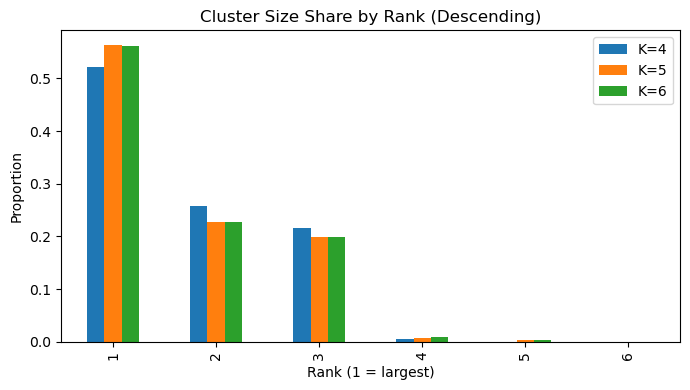

In [16]:
def evaluate_k(k):
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score

    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)

    sizes = pd.Series(labels).value_counts(normalize=True).sort_index()
    sil = silhouette_score(X_scaled, labels)

    return sizes, sil

sizes4, sil4 = evaluate_k(4)
sizes5, sil5 = evaluate_k(5)
sizes6, sil6 = evaluate_k(6)

print("Silhouette K=4:", sil4)
print("Silhouette K=5:", sil5)
print("Silhouette K=6:", sil6)

print("Cluster size share K=4:")
print(sizes4)

print("Cluster size share K=5:")
print(sizes5)

print("Cluster size share K=6:")
print(sizes6)



def sizes_to_rank_df(sizes, label):
    s = sizes.sort_values(ascending=False).reset_index(drop=True)
    s.index = s.index + 1  # rank starts at 1
    return s.rename(label)

rank_df = pd.concat(
    [
        sizes_to_rank_df(sizes4, "K=4"),
        sizes_to_rank_df(sizes5, "K=5"),
        sizes_to_rank_df(sizes6, "K=6"),
    ],
    axis=1
).fillna(0)

ax = rank_df.plot(kind="bar", figsize=(7,4))
ax.set_title("Cluster Size Share by Rank (Descending)")
ax.set_xlabel("Rank (1 = largest)")
ax.set_ylabel("Proportion")
plt.tight_layout()
plt.show()

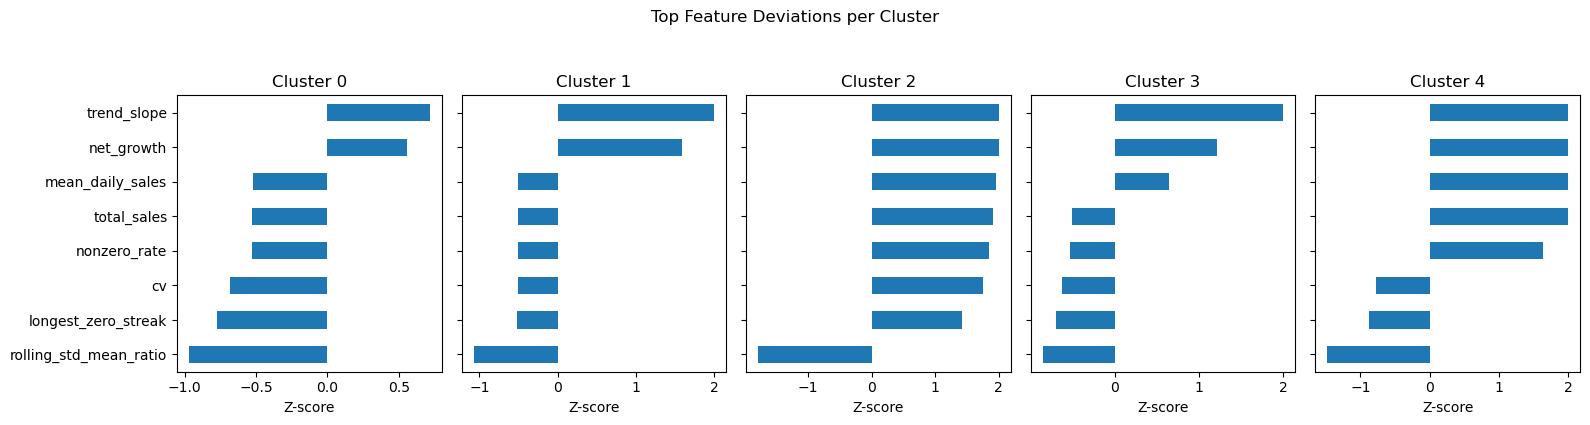

In [ ]:
top_n = 8
fig, axes = plt.subplots(1, len(Z), figsize=(16, 4), sharey=True)

for ax, (c, row) in zip(axes, Z.iterrows()):
    top = row.reindex(row.abs().sort_values(ascending=False).head(top_n).index)
    top.sort_values().plot(kind="barh", ax=ax, color="tab:blue")
    ax.set_title(f"Cluster {c}")
    ax.set_xlabel("Z-score")

plt.suptitle("Top Feature Deviations per Cluster", y=1.05)
plt.tight_layout()
plt.show()


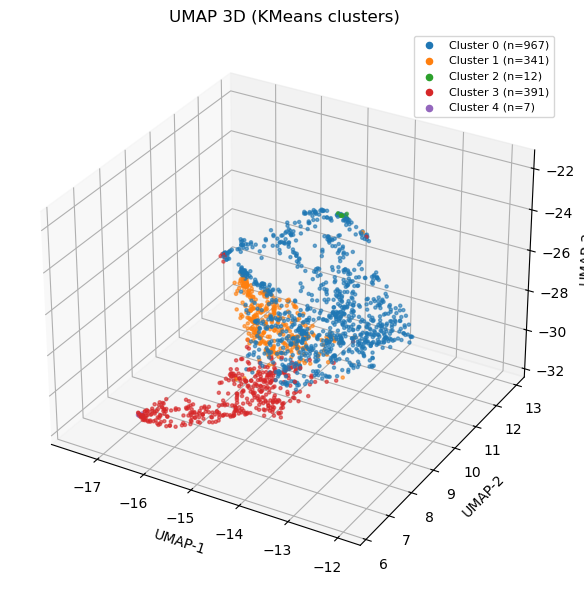

In [ ]:
from matplotlib.colors import ListedColormap
import umap

# --- load features (scaled) ---
X = pd.read_parquet(out_dir / "feature_table_extended_scaled.parquet")

# --- load labels ---
labels = pd.read_parquet(out_dir / "clusters_3models.parquet")
if "cluster_kmeans" not in labels.columns:
    labels = pd.read_parquet(out_dir / "clusters_gmm_kmeans.parquet")

df = X.join(labels[["cluster_kmeans"]])

# reindex clusters to 0..4 (5 colors only)
clusters = sorted(df["cluster_kmeans"].unique())
cluster_map = {c: i for i, c in enumerate(clusters)}
df["cluster_idx"] = df["cluster_kmeans"].map(cluster_map)

# 5-color palette
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
cmap = ListedColormap(colors)

# UMAP 3D
emb = umap.UMAP(n_components=3, n_neighbors=30, min_dist=0.1, random_state=42) \
           .fit_transform(df.drop(columns=["cluster_kmeans","cluster_idx"]).values)

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(emb[:,0], emb[:,1], emb[:,2], c=df["cluster_idx"], cmap=cmap, s=5, alpha=0.6)

ax.set_title("UMAP 3D (KMeans clusters)")
ax.set_xlabel("UMAP-1"); ax.set_ylabel("UMAP-2"); ax.set_zlabel("UMAP-3")

# legend with counts
for c, idx in cluster_map.items():
    n = (df["cluster_kmeans"] == c).sum()
    ax.scatter([], [], [], color=colors[idx], label=f"Cluster {c} (n={n})")
ax.legend(loc="best", fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
import umap
import plotly.express as px

# load features + labels
X = pd.read_parquet(out_dir / "feature_table_extended_scaled.parquet")
labels = pd.read_parquet(out_dir / "clusters_3models.parquet")
df = X.join(labels[["cluster_kmeans"]])

# 3D UMAP embedding
emb = umap.UMAP(n_components=3, n_neighbors=30, min_dist=0.1, random_state=42) \
          .fit_transform(df.drop(columns=["cluster_kmeans"]).values)

plot_df = pd.DataFrame(emb, columns=["UMAP1","UMAP2","UMAP3"])
plot_df["cluster"] = df["cluster_kmeans"].values

fig = px.scatter_3d(
    plot_df, x="UMAP1", y="UMAP2", z="UMAP3",
    color="cluster", opacity=0.7
)
fig.update_traces(marker=dict(size=3))
fig.update_layout(title="UMAP 3D (Interactive)")
fig.show()
